# Transfer Learning

## Task 2 (50 points)

Read about Transfer Learning from chapter 14 of [this textbook](https://learning.oreilly.com/library/view/hands-on-machine-learning/9781098125967/ch14.html) and replicate the results for the model described for the dataset  ```tf_flowers```.  The code for this task is in [this notebook](https://github.com/ageron/handson-ml3/blob/main/14_deep_computer_vision_with_cnns.ipynb) and you need to copy the **relavant** code into a separate notebook.

Produce classification results with and without transfer learning and compare the results.

# Task 2

In [ ]:
# Confirm connection to GPU with tensorflow
import tensorflow as tf
print(tf.version.VERSION)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

2.12.0
Found GPU at: /device:GPU:0


In [ ]:
# import necessary libraries
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tabulate import tabulate

In [ ]:
# load dataset and retrieve info
dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)
dataset_size = info.splits["train"].num_examples
class_names = info.features["label"].names
n_classes = info.features["label"].num_classes

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [ ]:
# print dataset size
dataset_size

3670

In [ ]:
# print class names
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [ ]:
#print number of classes
n_classes

5

In [ ]:
# split into test, validation, and train sets
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:15%]", "train[15%:30%]", "train[30%:]"],
    as_supervised=True)

In [ ]:
tf.keras.backend.clear_session()  # extra code – resets layer name counter

# setting of batch size and preprocessing of train, validation, and test sets
batch_size = 32
preprocess = tf.keras.Sequential([
    tf.keras.layers.Resizing(height=224, width=224, crop_to_aspect_ratio=True),
    tf.keras.layers.Lambda(tf.keras.applications.xception.preprocess_input)
])
train_set = train_set_raw.map(lambda X, y: (preprocess(X), y))
train_set = train_set.shuffle(1000, seed=123).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)
test_set = test_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)

## With Transfer Learning

In [ ]:
# create base model and build model architecture
tf.random.set_seed(123)  # extra code – ensures reproducibility
base_model = tf.keras.applications.xception.Xception(weights="imagenet",
                                                     include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
class_output = tf.keras.layers.Dense(n_classes, activation="softmax")(avg)
loc_output = tf.keras.layers.Dense(4)(avg)
with_tl_model = tf.keras.Model(inputs=base_model.input,
                       outputs=[class_output, loc_output])
# configure optimizer, compile and train model
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
with_tl_model.compile(loss=["sparse_categorical_crossentropy", "mse"],
              loss_weights=[0.8, 0.2],  # depends on what you care most about
              optimizer=optimizer, metrics=["accuracy"])

83683744/83683744 [==============================] - 1s 0us/step


In [ ]:
with_tl = with_tl_model.fit(train_set, validation_data=valid_set, epochs=10)

Epoch 1/10
81/81 [==============================] - 90s 560ms/step - loss: 0.7989 - dense_loss: 0.6833 - dense_1_loss: 1.2613 - dense_accuracy: 0.7540 - dense_1_accuracy: 0.2176 - val_loss: 0.4301 - val_dense_loss: 0.3484 - val_dense_1_loss: 0.7571 - val_dense_accuracy: 0.8748 - val_dense_1_accuracy: 0.2087
Epoch 2/10
81/81 [==============================] - 43s 519ms/step - loss: 0.1724 - dense_loss: 0.1365 - dense_1_loss: 0.3158 - dense_accuracy: 0.9580 - dense_1_accuracy: 0.2114 - val_loss: 0.2837 - val_dense_loss: 0.2092 - val_dense_1_loss: 0.5818 - val_dense_accuracy: 0.9147 - val_dense_1_accuracy: 0.1561
Epoch 3/10
81/81 [==============================] - 44s 530ms/step - loss: 0.0720 - dense_loss: 0.0438 - dense_1_loss: 0.1850 - dense_accuracy: 0.9914 - dense_1_accuracy: 0.2133 - val_loss: 0.2298 - val_dense_loss: 0.1858 - val_dense_1_loss: 0.4057 - val_dense_accuracy: 0.9383 - val_dense_1_accuracy: 0.1924
Epoch 4/10
81/81 [==============================] - 44s 528ms/step - loss

## Without Transfer Learning

In [ ]:
# create custom model architecture
without_tl_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(n_classes, activation='softmax')
])
# configure optimizer, compile, and train the model
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
without_tl_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [ ]:
without_tl = without_tl_model.fit(train_set, validation_data=valid_set, epochs=10)

Epoch 1/10
81/81 [==============================] - 11s 92ms/step - loss: 1.3218 - accuracy: 0.4278 - val_loss: 1.2355 - val_accuracy: 0.4392
Epoch 2/10
81/81 [==============================] - 7s 78ms/step - loss: 1.0989 - accuracy: 0.5395 - val_loss: 1.1163 - val_accuracy: 0.5699
Epoch 3/10
81/81 [==============================] - 8s 81ms/step - loss: 1.0245 - accuracy: 0.5893 - val_loss: 0.9824 - val_accuracy: 0.6152
Epoch 4/10
81/81 [==============================] - 7s 81ms/step - loss: 0.8454 - accuracy: 0.6652 - val_loss: 0.9834 - val_accuracy: 0.6261
Epoch 5/10
81/81 [==============================] - 7s 78ms/step - loss: 0.6604 - accuracy: 0.7443 - val_loss: 1.0792 - val_accuracy: 0.5735
Epoch 6/10
81/81 [==============================] - 7s 81ms/step - loss: 0.5147 - accuracy: 0.7867 - val_loss: 1.1571 - val_accuracy: 0.6134
Epoch 7/10
81/81 [==============================] - 7s 81ms/step - loss: 0.3132 - accuracy: 0.8922 - val_loss: 1.2312 - val_accuracy: 0.6243
Epoch 8/10
8

## Comparison

Performance of the model with transfer learning was better than without transfer learning.

Comparison between 'with' and 'without' transfer learning:
╒═══════════════════════════╤══════════════════╤══════════════╤═══════════════════════╤═══════════════════╕
│ Transfer Learning         │   Train Accuracy │   Train Loss │   Validation Accuracy │   Validation Loss │
╞═══════════════════════════╪══════════════════╪══════════════╪═══════════════════════╪═══════════════════╡
│ With Transfer Learning    │           0.9996 │       0.0052 │                0.9328 │            0.2088 │
├───────────────────────────┼──────────────────┼──────────────┼───────────────────────┼───────────────────┤
│ Without Transfer Learning │           0.9517 │       0.1391 │                0.5971 │            1.8579 │
╘═══════════════════════════╧══════════════════╧══════════════╧═══════════════════════╧═══════════════════╛


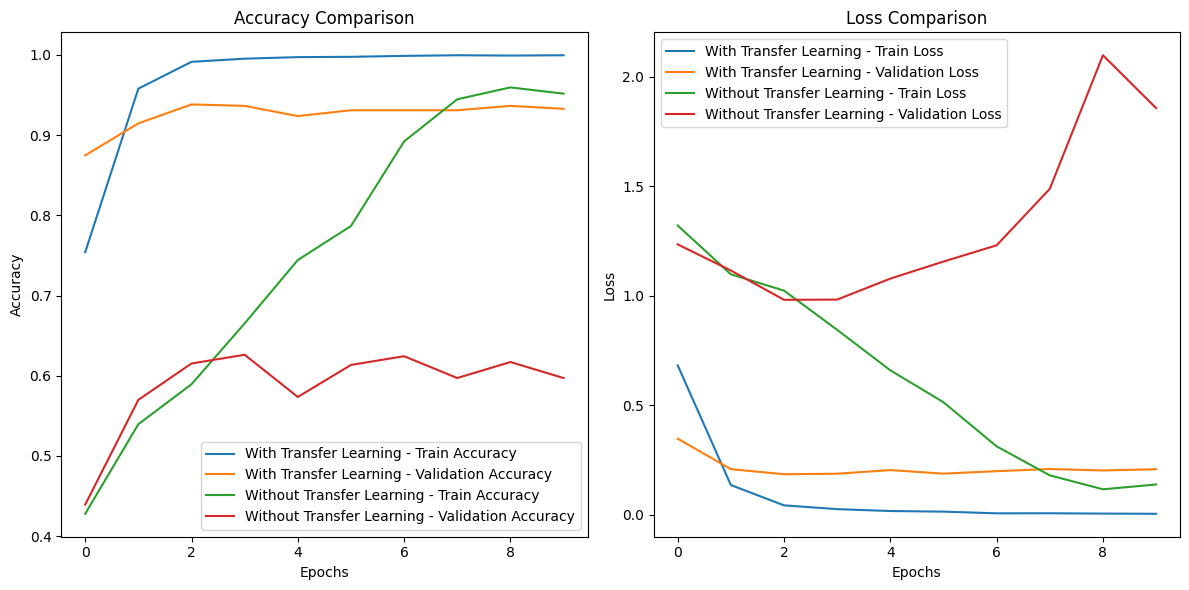

In [ ]:
# Create a table to display the comparison
table_data = [
    ["Transfer Learning", "Train Accuracy", "Train Loss", "Validation Accuracy", "Validation Loss"],
    ["With Transfer Learning", "{:.4f}".format(with_tl.history['dense_accuracy'][-1]), "{:.4f}".format(with_tl.history['dense_loss'][-1]), "{:.4f}".format(with_tl.history['val_dense_accuracy'][-1]), "{:.4f}".format(with_tl.history['val_dense_loss'][-1])],
    ["Without Transfer Learning", "{:.4f}".format(without_tl.history['accuracy'][-1]), "{:.4f}".format(without_tl.history['loss'][-1]), "{:.4f}".format(without_tl.history['val_accuracy'][-1]), "{:.4f}".format(without_tl.history['val_loss'][-1])]
]

# Print the comparison table
print("Comparison between 'with' and 'without' transfer learning:")
print(tabulate(table_data, headers="firstrow", tablefmt="fancy_grid"))

# Plot metrics for "with" and "without" transfer learning in the same plot
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(with_tl.history['dense_accuracy'], label='With Transfer Learning - Train Accuracy')
plt.plot(with_tl.history['val_dense_accuracy'], label='With Transfer Learning - Validation Accuracy')
plt.plot(without_tl.history['accuracy'], label='Without Transfer Learning - Train Accuracy')
plt.plot(without_tl.history['val_accuracy'], label='Without Transfer Learning - Validation Accuracy')
plt.title("Accuracy Comparison")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(with_tl.history['dense_loss'], label='With Transfer Learning - Train Loss')
plt.plot(with_tl.history['val_dense_loss'], label='With Transfer Learning - Validation Loss')
plt.plot(without_tl.history['loss'], label='Without Transfer Learning - Train Loss')
plt.plot(without_tl.history['val_loss'], label='Without Transfer Learning - Validation Loss')
plt.title("Loss Comparison")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()